# Import library

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy, copy
import functools
import os
import cProfile
import pstats
from multiprocessing import Pool

## Random seed

In [112]:
RANDOM_SEED = 12
np.random.seed(RANDOM_SEED)

# Function to transform the data

In [113]:
# Function to transfer from dBW to W (power)
def db2pow(db: float) -> float:
    return 10**(db/10)

# Function to transfer from W to dBW (power)
def pow2db(pow: float) -> float:
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x: np.ndarray) -> np.ndarray:
    return x.conj().T

def chanGen(zeta: float, d: float, dim1: int, dim2: int) -> np.ndarray:
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref: float = -30                                    # pathloss (dBW) at reference distance
    pl: float = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y: np.ndarray = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y

## Read input data & Parameters

In [114]:
sigma = db2pow(-75)                                                                 # noise power
N = 10                                                                              # number of transmit antennas
gamma = 0.8 # Lower bound for user's link quality
pmax = 1000  # Maximum transmit power of Alice

# Channel generation
def read_general_channel() -> tuple:
    filepath = './data/general/'
    Hai = np.load(filepath + 'Hai.npy')
    hib = np.load(filepath + 'hib.npy')
    hab = np.load(filepath + 'hab.npy')
    hie = np.load(filepath + 'hie.npy')
    hae = np.load(filepath + 'hae.npy')
    return Hai, hib, hie, hab, hae

def read_fixed_eaves(num_of_users, num_of_eavesdroppers) -> tuple:
    filepath = f'./data/fixed_eaves/data_{num_of_users}users_{num_of_eavesdroppers}eaves/{RANDOM_SEED}_set/'
    Hai = np.load(filepath + 'Hai.npy')
    hib = np.load(filepath + 'hib.npy')
    hab = np.load(filepath + 'hab.npy')
    hie = np.load(filepath + 'hie.npy')
    hae = np.load(filepath + 'hae.npy')
    return Hai, hib, hie, hab, hae

def read_fixed_users(num_of_users, num_of_eavesdroppers) -> tuple:
    filepath = f'./data/fixed_users/data_{num_of_users}users_{num_of_eavesdroppers}eaves/{RANDOM_SEED}_set/'
    Hai = np.load(filepath + 'Hai.npy')
    hib = np.load(filepath + 'hib.npy')
    hab = np.load(filepath + 'hab.npy')
    hie = np.load(filepath + 'hie.npy')
    hae = np.load(filepath + 'hae.npy')
    return Hai, hib, hie, hab, hae

#Hai: Channel between Alice and RIS: Nris x N  
#hib: Channel between RIS and users: List of length number_of_users, elements are 1 x Nris
#hab: Channel between Alice and users: List of length number_of_users, elements are 1 x N
#hie: Channel between RIS and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x Nris
#hae: Channel between Alice and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x N

Hai, hib, hie, hab, hae = read_fixed_users(6, 5)

Nris = Hai.shape[0]                                                                       
number_of_users = len(hib)
number_of_eavesdroppers = len(hie)
print(f'Number of users: {number_of_users}')
print(f'Number of eavesdroppers: {number_of_eavesdroppers}')


Number of users: 6
Number of eavesdroppers: 5


# Beamforming vectors and RIS functions

In [115]:
def normalise_beamforming_vectors(w: np.ndarray) -> np.ndarray:
    """Function to normalise the beamforming vectors

      Args:
        w: the beamforming vectors
    """
    total_norm_squared = 0
    for i in range(number_of_users):
      total_norm_squared += (np.linalg.norm(w[i]) ** 2)
    for i in range(number_of_users):
      w[i] = w[i] / (total_norm_squared ** 0.5) * np.sqrt(pmax)
    return w

def generate_random_beamforming_vector() -> np.ndarray:
    '''
    Generate one random beamforming vector
    '''
    return np.random.uniform(-1, 1, (N, 1)) + 1j * np.random.uniform(-1, 1, (N, 1))

def generate_random_beamforming_vectors() -> list[np.ndarray]:
    '''
    Generate a list of normalised random beamforming vectors
    '''
    # Generate random complex numbers for each element of the beamforming vector
    beamforming_vectors = [generate_random_beamforming_vector() for _ in range (number_of_users)]
    
    # Normalize the vectors
    beamforming_vectors = normalise_beamforming_vectors(beamforming_vectors)
    return beamforming_vectors
    # w: list of beamforming vectors, length = number of users, elements are N x 1

def generate_random_theta_vector() -> np.ndarray:
    """
    Generate a random vector of complex numbers on the unit circle
    """
    theta = np.random.uniform(-np.pi, np.pi, (1, Nris))
    theta = np.exp(1j * theta)
    return theta
    # theta: phase shift of RIS, size 1 x Nris

def generate_random_theta_angles(size: int):
  """
    Generate a random vector of angles from -pi to pi
  """
  return np.random.uniform(-np.pi, np.pi, size=(1, size))

def theta_angles_to_theta_vector(angles: np.ndarray[np.float64]) -> np.ndarray[np.complex128]:
  """
    Convert a vector of angles to a vector of complex numbers on the unit circle
  """
  return np.exp(1j * angles)

def theta_vector_to_theta_angles(theta: np.ndarray[np.complex128]) -> np.ndarray[np.float64]:
  """
    Convert a vector of complex numbers on the unit circle to a vector of angles
  """
  return np.angle(theta)



    

# Objective Function

In [116]:
def secrecy_rate_objective_function(theta, w) -> float:
    """
    Objective function for the secrecy rate
    """
    secrecy_rate: float = 0
    for k in range(number_of_users):
        R_bk = []
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        for m in range(number_of_eavesdroppers):
            # Eavesdropper i
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            C_em = np.log2(1 + gamma_em)
            R_bk.append(C_bk - C_em)
        
        secrecy_rate += max(min(R_bk),float(0))

    # Return the only element in the matrix as it is currently a 1x1 np array
    return float(secrecy_rate)


def check_validity(theta, w) -> int:
    """
    Check if the current set up is valid (every users' C_bk >= gamma)
    
    Return: 
        The index of the invalid user whose C_bk is highest among the invalid, or -1 if all users are valid
    """
    user = -1
    maxx = 0
    for k in range(number_of_users):
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        if (C_bk < gamma):
            if C_bk > maxx:
                maxx = C_bk
                user = k
    return user


def print_users_Cbk(theta, w) -> None:
    """
    Print the C_bk of all users
    """
    print("User's Cbk: ", end ="")
    for k in range(number_of_users):
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        print(float(C_bk), end = " ")
    print()

def calculate_user_Cbk(theta, w, user) -> float:
    """
    Calculate the C_bk of a user
    """
    Z_bk = hib[user] @ np.diag(theta.flatten()) @ Hai + hab[user]
    numGamma_bk = np.abs(Z_bk @ w[user])**2
    denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != user])
    gamma_bk = numGamma_bk/denGamma_bk
    C_bk = np.log2(1 + gamma_bk)
    return C_bk


def repair_beamforming_vectors(theta, w, user, learning_rate = 0.01, max_iter = 500):
    """
    Repair the beamforming vectors of a user by using gradient descent to repair the beamforming vector of that user
    
    Try to make that user's C_bk >= gamma + 0.2
    """
    while (calculate_user_Cbk(theta, w, user) < gamma + 0.4 and max_iter > 0):
        Z_bk = hib[user] @ np.diag(theta.flatten()) @ Hai + hab[user]
        numGamma_bk = np.abs(Z_bk @ w[user])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != user])
        gamma_bk = numGamma_bk/denGamma_bk
        
        num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_bk) @ Z_bk @ w[user])
        den_grad_C_bk_to_w_k = (1 + gamma_bk) * np.log(2) * (1 + sum([abs(Z_bk @ w[j]) for j in range (number_of_users) if j != user]))
        grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k
        w[user] = w[user] + learning_rate * grad_C_bk_to_w_k
        max_iter -= 1

        w = normalise_beamforming_vectors(w)
    return w


def repair(theta, w, iter = 100):
    """
        Using gradient descent to repair the (theta, w) set up
    """
    invalid_user = check_validity(theta, w)
    while (invalid_user != -1 and iter > 0):
        w = repair_beamforming_vectors(theta, w, invalid_user)
        invalid_user = check_validity(theta, w)
        iter -= 1
    if (invalid_user != -1):
        theta, w = generate_random_theta_vector(), generate_random_beamforming_vectors()
        return repair(theta, w)
    return theta, w

    


# Method

## Gradient Descent for Maximization (GD)

In [117]:
def compute_gradient_w(theta, w) -> list[np.ndarray]:
    """
    Compute the gradient of the beamforming vectors
    """
    grad_w = []
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    
    #Precalculation 
    for k in range(number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])


    #Calculating grad for i-th beamforming vector
    for i in range(number_of_users):
        grad = np.zeros((N, 1))
        for k in range (number_of_users):
            if (counted[k] == False):
                continue
            if (k == i):
                num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[k])
                den_grad_C_bk_to_w_k = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k

                num_grad_C_e_max_to_w_k = 2 * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[k])
                den_grad_C_e_max_to_w_k = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_e_max_to_w_k = num_grad_C_e_max_to_w_k / den_grad_C_e_max_to_w_k
                
                grad = grad - (grad_C_bk_to_w_k - grad_C_e_max_to_w_k)
            else:
                num_grad_C_bk_to_w_i = -2 * abs(Z_b[k] @ w[k]) * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[i])
                den_grad_C_bk_to_w_i = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_bk_to_w_i = num_grad_C_bk_to_w_i / den_grad_C_bk_to_w_i

                num_grad_C_e_max_to_w_i = -2 * abs(Z_e_max[k] @ w[k]) * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[i])
                den_grad_C_e_max_to_w_i = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_e_max_to_w_i = num_grad_C_e_max_to_w_i / den_grad_C_e_max_to_w_i

                grad = grad - (grad_C_bk_to_w_i - grad_C_e_max_to_w_i)
            
        grad_w.append(grad)
    return grad_w

def compute_gradient_theta(theta, w):
    """
    Compute the gradient of theta

    Args:
        theta: the phase shift of the RIS in vector form
        w: the beamforming vectors
    """
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    index_e_max_list = []
    #Precalculation
    for k in range(number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        index_e_max_list.append(index_e_max)
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])

    grad_theta = 0

    for k in range(number_of_users):
        if (counted[k] == False):
            continue

        grad_Z_bk_wk_to_theta = (1/sigma) * np.diag(hib[k].flatten()) @ Hai @ w[k]
        grad_gamma_bk_to_theta_first_term = (2 * (Z_b[k] @ w[k]) * grad_Z_bk_wk_to_theta) * (1 + sum([np.linalg.norm(Z_b[k] @ w[j])**2 for j in range (number_of_users) if j != k]))
        grad_gamma_bk_to_theta_second_term = sum([2 * (Z_b[k] @ w[j]) * grad_Z_bk_wk_to_theta for j in range(number_of_users) if j != k]) * (np.linalg.norm(Z_b[k] @ w[k]) ** 2)
        grad_gamma_bk_to_theta_third_term = (1 + sum([np.linalg.norm(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])**2) ** 2
        grad_gamma_bk_to_theta = (grad_gamma_bk_to_theta_first_term - grad_gamma_bk_to_theta_second_term) / grad_gamma_bk_to_theta_third_term

        grad_C_bk_to_theta = 1 / ((1 + gamma_b[k]) * np.log(2)) * grad_gamma_bk_to_theta

        grad_Z_emax_wk_to_theta = (1/sigma) * np.diag(hie[index_e_max_list[k]].flatten()) @ Hai @ w[k]

        grad_gamma_emax_to_theta_first_term = (2 * (Z_e_max[k] @ w[k]) * grad_Z_emax_wk_to_theta) * (1 + sum([np.linalg.norm(Z_e_max[k] @ w[j])**2 for j in range (number_of_users) if j != k]))
        grad_gamma_emax_to_theta_second_term = sum([2 * (Z_e_max[k] @ w[j]) * grad_Z_emax_wk_to_theta for j in range(number_of_users) if j != k]) * (np.linalg.norm(Z_e_max[k] @ w[k]) ** 2)
        grad_gamma_emax_to_theta_third_term = (1 + sum([np.linalg.norm(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])**2) ** 2
        grad_gamma_emax_to_theta = (grad_gamma_emax_to_theta_first_term - grad_gamma_emax_to_theta_second_term) / grad_gamma_emax_to_theta_third_term

        grad_C_emax_to_theta = 1 / ((1 + gamma_e_max[k]) * np.log(2)) * grad_gamma_emax_to_theta

        grad_theta -= (grad_C_bk_to_theta - grad_C_emax_to_theta)
    
    return np.array(grad_theta).reshape((1, Nris))
    


def gradient_descent_update(w, theta, learning_rate):
    grad_w = compute_gradient_w(theta, w)
    grad_theta = compute_gradient_theta(theta, w)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    w_new = normalise_beamforming_vectors(w_new)
        
    theta_new = theta - learning_rate * grad_theta
    theta_new = np.exp(1j * np.angle(theta_new))

    return w_new, theta_new

In [118]:
# Reseed first
np.random.seed(RANDOM_SEED)

# Gradient Descent Algorithm
num_cycles = 500
learning_rate = 0.01
theta_GD = generate_random_theta_vector()
w_GD = generate_random_beamforming_vectors()
theta_GD, w_GD = repair(theta_GD, w_GD)
print("Initial Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
current_secrecy_rate = secrecy_rate_objective_function(theta_GD, w_GD)

GD_results = []
GD_results.append(current_secrecy_rate)

for i in range(num_cycles):
    print("Iteration", i)
    print("Secrecy Rate:", current_secrecy_rate)
    w_new, theta_new = gradient_descent_update(w_GD, theta_GD, learning_rate)
    
    new_secrecy_rate = secrecy_rate_objective_function(theta_new, w_new)
    if (new_secrecy_rate - current_secrecy_rate) < 1e-9:
        print("Converged")
        break
    w_GD = w_new
    theta_GD = theta_new
    GD_results.append(new_secrecy_rate)
    current_secrecy_rate = new_secrecy_rate

theta_GD, w_GD = repair(theta_GD, w_GD)
print("Final Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
print_users_Cbk(theta_GD, w_GD)

Initial Secrecy Rate GD: 3.1315031744352813
Iteration 0
Secrecy Rate: 3.1315031744352813
Converged
Final Secrecy Rate GD: 3.1315031744352813
User's Cbk: 0.9610233158552898 1.1181291560276179 1.2225794727455548 0.8158900466484705 1.0080748997477544 0.9793855836725399 


C:\Users\11\AppData\Local\Temp\ipykernel_10612\2597543351.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(secrecy_rate)
C:\Users\11\AppData\Local\Temp\ipykernel_10612\2597543351.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float(C_bk), end = " ")


## Particle Swarm Optimization (PSO)

In [119]:
class PSOParticle:
  def __init__(self) -> None:
    self.theta = generate_random_theta_angles(Nris)
    self.w = generate_random_beamforming_vectors()

    self.theta, self.w = repair(theta_angles_to_theta_vector(self.theta), self.w)
    self.theta = theta_angles_to_theta_vector(self.theta)
    
    self.best_theta = self.theta #deepcopy(self.theta)
    self.best_w = self.w #deepcopy(self.w)
    self.best_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.best_theta), self.best_w)
    self.current_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)
    self.velocity_theta = np.zeros((1, Nris))
    self.velocity_w = [np.zeros((N, 1)) for _ in range(number_of_users)]

  def update_velocity(self, inertia, c1, c2, global_best_theta, global_best_w):
    r1 = np.random.rand()
    r2 = np.random.rand()
    self.velocity_theta = inertia * self.velocity_theta + c1 * r1 * (self.best_theta - self.theta) + c2 * r2 * (global_best_theta - self.theta)
    self.velocity_w = [inertia * self.velocity_w[i] + c1 * r1 * (self.best_w[i] - self.w[i]) + c2 * r2 * (global_best_w[i] - self.w[i]) for i in range(number_of_users)]

  def update_position(self):
    self.theta = self.theta + self.velocity_theta
    self.w = [self.w[i] + self.velocity_w[i] for i in range(number_of_users)]
    self.w = normalise_beamforming_vectors(self.w)

  def update_best(self):
    self.current_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)
    if self.current_secrecy_rate > self.best_secrecy_rate:
      self.best_secrecy_rate = self.current_secrecy_rate
      self.best_theta = self.theta #deepcopy(self.theta)
      self.best_w = self.w #deepcopy(self.w)

In [120]:
def dynamic_inertia(i: int, max_iter: int, inertia_max: float, inertia_min: float) -> float:
  E_t = float((max_iter - i - 1)/max_iter)
  inertia = inertia_min + (inertia_max - inertia_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)
  return inertia

In [121]:
def PSO_optimize_w_theta(max_iter: int, num_particles: int, w_min: float, w_max: float, c1: float, c2: float):
  particles = [PSOParticle() for _ in range(num_particles)]
  global_best_secrecy_rate = -np.inf
  global_best_theta = np.zeros((1, Nris))
  global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  results_secrecy_rate = []

  for particle in particles:
    if particle.best_secrecy_rate > global_best_secrecy_rate:
      global_best_secrecy_rate = particle.best_secrecy_rate
      global_best_theta = particle.best_theta #deepcopy(particle.best_theta)
      global_best_w = particle.best_w #deepcopy(particle.best_w)

  results_secrecy_rate.append(global_best_secrecy_rate)

  for iteration in range(max_iter):
    print("iteration =", iteration, global_best_secrecy_rate)
    print_users_Cbk(theta_angles_to_theta_vector(global_best_theta), global_best_w)
    inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

    for particle in particles:
      particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
      particle.update_position()
      particle.theta, particle.w = repair(theta_angles_to_theta_vector(particle.theta), particle.w)
      particle.theta = theta_vector_to_theta_angles(particle.theta)
      particle.update_best()

      if particle.best_secrecy_rate > global_best_secrecy_rate:
        global_best_secrecy_rate = particle.best_secrecy_rate
        global_best_theta = particle.best_theta #deepcopy(particle.best_theta)
        global_best_w = particle.best_w #deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)
   

  return results_secrecy_rate

In [122]:
# Reseed
np.random.seed(RANDOM_SEED)

# PSO Algorithm
max_iter = 500
num_particles = 100
w_min = 0.5
w_max = 0.9
c1 = 1.5
c2 = 1.5

PSO_results = PSO_optimize_w_theta(max_iter, num_particles, w_min, w_max, c1, c2)
print("Initial Secrecy Rate PSO:", PSO_results[0])
print(PSO_results)
print("Final Secrecy Rate PSO:", PSO_results[-1])

C:\Users\11\AppData\Local\Temp\ipykernel_10612\2597543351.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(secrecy_rate)


KeyboardInterrupt: 

## Genetic Algorithm (GA)

In [ ]:
class GAIndividual:
  def __init__(self, theta: np.ndarray[np.float64] = None, w: np.ndarray[np.complex128] = None) -> None:
    if theta is None or w is None:
      self.theta = generate_random_theta_angles(Nris)
      self.w = generate_random_beamforming_vectors()
    else:
      self.theta = theta
      self.w = w
    self.theta, self.w = repair(theta_angles_to_theta_vector(self.theta), self.w)
    self.theta = theta_vector_to_theta_angles(self.theta)
    self.update_fitness()
  
  def update_fitness(self):
    self.fitness = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)


class GAPopulation:
  def __init__(self, population_size: int, crossover_rate: float = 0.85, mutation_rate: float = 0.3) -> None:
    self.population_size = population_size
    self.individuals = [GAIndividual() for _ in range(population_size)]
    self.crossover_rate = crossover_rate
    self.mutation_rate = mutation_rate

  def sort_population(self):
    self.individuals.sort(key=lambda x: x.fitness, reverse=True)

  def filter_population(self):
    self.sort_population()
    self.individuals = self.individuals[:self.population_size]

  def add_individual(self, individual: GAIndividual):
    self.individuals.append(individual) #deepcopy?

  def select_parents(self) -> tuple[GAIndividual, GAIndividual]:
    parents = np.random.choice(self.individuals, 2, replace=False)
    return parents[0], parents[1]
  
  def crossover(self, parent1: GAIndividual, parent2: GAIndividual) -> GAIndividual:
    theta1, w1 = parent1.theta, parent1.w
    theta2, w2 = parent2.theta, parent2.w
    theta_child = (theta1 + theta2) / 2
    w_child = [(w1[i] + w2[i]) / 2 for i in range(number_of_users)]
    w_child = normalise_beamforming_vectors(w_child)
    return GAIndividual(theta_child, w_child)
  
  def mutate(self, individual: GAIndividual) -> GAIndividual:
    if np.random.rand() < self.mutation_rate:
      mutation_index = np.random.randint(0, Nris)
      individual.theta[0, mutation_index] = np.random.uniform(-np.pi, np.pi)
      mutation_index = np.random.randint(len(individual.w))
      individual.w[mutation_index] = generate_random_beamforming_vector()
      individual.w = normalise_beamforming_vectors(individual.w)
      individual.update_fitness()

    return individual
  
def GA_optimize_w_theta(population_size: int, max_iter: int, crossover_rate: float = 0.85, mutation_rate: float = 0.85):
  population = GAPopulation(population_size, crossover_rate, mutation_rate)
  population.sort_population()
  results_secrecy_rate = []
  results_secrecy_rate.append(population.individuals[0].fitness)

  for iteration in range(max_iter):
    print("iteration =", iteration, population.individuals[0].fitness)
    # Crossover and mutate
    list_of_child = []
    for _ in range(population_size):
      if np.random.rand() < population.crossover_rate:
        parent1, parent2 = population.select_parents()
        child = population.crossover(parent1, parent2)
      
        if np.random.rand() < population.mutation_rate:
          population.mutate(child)
      
        child.theta, child.w = repair(theta_angles_to_theta_vector(child.theta), child.w)
        child.theta = theta_vector_to_theta_angles(child.theta)
        list_of_child.append(child)
      for child in list_of_child:
        population.add_individual(child)
    # Filter
    population.filter_population()
    population.sort_population()
    results_secrecy_rate.append(population.individuals[0].fitness)
    print_users_Cbk(theta_angles_to_theta_vector(population.individuals[0].theta), population.individuals[0].w)
  return results_secrecy_rate

In [ ]:
population_size = 100
num_generations = 500
crossover_rate = 0.9
mutation_rate = 0.3

# Reseed
np.random.seed(RANDOM_SEED)

# GA Algorithm
GA_results = GA_optimize_w_theta(population_size, num_generations, crossover_rate, mutation_rate)
print("Initial Secrecy Rate GA:", GA_results[0])
print(GA_results)
print("Final Secrecy Rate GA:", GA_results[-1])

C:\Users\11\AppData\Local\Temp\ipykernel_10612\2597543351.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(secrecy_rate)


iteration = 0 6.332541421454047
User's Cbk: 1.7300005706421206 1.3333520051610577 1.6229002262297687 0.8841291273992045 2.077359792129981 2.2885424874704547 
iteration = 1 9.486323133550838


C:\Users\11\AppData\Local\Temp\ipykernel_10612\2597543351.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float(C_bk), end = " ")


User's Cbk: 1.4225031344315977 1.101686012534711 2.0788851367728807 0.9901889210835705 2.267233252107375 3.0543900726155973 
iteration = 2 10.652249941319855
User's Cbk: 1.4225031344315977 1.101686012534711 2.0788851367728807 0.9901889210835705 2.267233252107375 3.0543900726155973 
iteration = 3 10.652249941319855
User's Cbk: 1.504891896674723 1.1229384655010108 2.311194618761587 1.0373530038232783 2.0193187503790955 3.142694594344513 
iteration = 4 10.889352975306192
User's Cbk: 1.4577875551436188 1.3680075455935001 2.0864390091827127 1.016171707302606 2.096431030993965 3.2823405356944373 
iteration = 5 11.084015052133818
User's Cbk: 1.4577875551436188 1.3680075455935001 2.0864390091827127 1.016171707302606 2.096431030993965 3.2823405356944373 
iteration = 6 11.084015052133818
User's Cbk: 1.4970140333903845 1.213944593475695 2.2319820746601784 1.0579639304596982 2.094454500756422 3.2369806738720808 
iteration = 7 11.110296137869689
User's Cbk: 1.4970140333903845 1.213944593475695 2.23

## Combination of PSO and GD

In [ ]:
def PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, learning_rate, w_max, w_min, c1, c2):
    particles = [PSOParticle() for _ in range(number_of_particles)]
    global_best_secrecy_rate = -np.inf
    global_best_theta = np.zeros((1, Nris))
    global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

    results_secrecy_rate = []

    for particle in particles:
        if particle.best_secrecy_rate > global_best_secrecy_rate:
            global_best_secrecy_rate = particle.best_secrecy_rate
            global_best_theta = particle.best_theta #deepcopy(particle.best_theta)
            global_best_w = particle.best_w #deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)
    
    for iteration in range(max_pso_iter):
        print("iteration =", iteration, "Global Best Secrecy Rate:", global_best_secrecy_rate)
        print_users_Cbk(theta_angles_to_theta_vector(global_best_theta), global_best_w)
        inertia = dynamic_inertia(iteration, max_pso_iter, w_max, w_min)

        for particle in particles:

            # Basic PSO
            particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
            particle.update_position()
            particle.theta, particle.w = repair(theta_angles_to_theta_vector(particle.theta), particle.w)
            particle.theta = theta_vector_to_theta_angles(particle.theta)
            
            for _ in range (max_gd_iter):
                new_w, new_theta = gradient_descent_update(particle.w, theta_angles_to_theta_vector(particle.theta), learning_rate)
                new_secrecy_rate = secrecy_rate_objective_function(new_theta, new_w)
                if (new_secrecy_rate - particle.current_secrecy_rate) < 1e-9:
                    break
                
                particle.w = new_w
                particle.theta = theta_vector_to_theta_angles(new_theta)
                particle.current_secrecy_rate = new_secrecy_rate
            
            particle.theta, particle.w = repair(theta_angles_to_theta_vector(particle.theta), particle.w)
            particle.theta = theta_vector_to_theta_angles(particle.theta)
            particle.update_best()
            
            if particle.best_secrecy_rate > global_best_secrecy_rate: 
                # No need to check validity as we already checked it in the inner loop
                global_best_secrecy_rate = particle.best_secrecy_rate
                global_best_theta = particle.best_theta #deepcopy(particle.best_theta)
                global_best_w = particle.best_w #deepcopy(particle.best_w)
       
        results_secrecy_rate.append(global_best_secrecy_rate)
    return results_secrecy_rate

In [ ]:
# Reseed
np.random.seed(RANDOM_SEED)

max_pso_iter = 500
max_gd_iter = 50
number_of_particles = 50
w_max = 0.9
w_min = 0.5
c1 = 1.5
c2 = 1.5

PSO_GD_results = PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, learning_rate, w_max, w_min, c1, c2)
print("Initial Secrecy Rate PSO-GD:", PSO_GD_results[0])
print("Final Secrecy Rate PSO-GD:", PSO_GD_results[-1])

C:\Users\11\AppData\Local\Temp\ipykernel_10612\2597543351.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(secrecy_rate)


iteration = 0 Global Best Secrecy Rate: 6.084997348772564
User's Cbk: 1.2481087614999777 1.0909205588402309 0.8984047327086399 0.9329911369744166 1.311968750157311 1.6336053306731662 


C:\Users\11\AppData\Local\Temp\ipykernel_10612\2597543351.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float(C_bk), end = " ")


iteration = 1 Global Best Secrecy Rate: 22.153574193149783
User's Cbk: 3.219567359984887 4.021542104083598 5.6808098596736345 0.9522022584607965 6.83097762901504 3.2474053691309552 
iteration = 2 Global Best Secrecy Rate: 22.30176681999713
User's Cbk: 3.212939751139111 4.080205625909692 5.8370500675171275 0.888518385680114 6.750172215015133 3.4111825377316713 
iteration = 3 Global Best Secrecy Rate: 23.212428541694763
User's Cbk: 3.034825572113333 4.143411197861409 5.7220094060268325 0.9889225914073634 7.741957631887543 3.4905507854496296 
iteration = 4 Global Best Secrecy Rate: 25.192618224632074
User's Cbk: 3.7582709759099586 4.296652367173699 5.796657034346104 0.9826498821305127 8.406522832473573 3.7649635972615023 
iteration = 5 Global Best Secrecy Rate: 26.174266361460422
User's Cbk: 3.8690466418354226 4.788259391375138 5.931147690085796 0.8362414043726527 8.771340342780734 3.8323069484448893 
iteration = 6 Global Best Secrecy Rate: 26.70147883653593
User's Cbk: 3.8746273600312957

# Combination of GA and GD

In [ ]:
def GA_GD_optimize_w_theta(population_size: int, max_iter: int, max_iter_gd: int, crossover_rate: float = 0.85, mutation_rate: float = 0.85):
  population = GAPopulation(population_size, crossover_rate, mutation_rate)
  population.sort_population()
  results_secrecy_rate = []
  results_secrecy_rate.append(population.individuals[0].fitness)

  for iteration in range(max_iter):
    print("iteration =", iteration)
    # Crossover
    list_of_child = []
    for _ in range(population_size):
      if np.random.rand() < population.crossover_rate:
        parent1, parent2 = population.select_parents()
        child = population.crossover(parent1, parent2)
    #Mutate 
        if np.random.rand() < population.mutation_rate:
          population.mutate(child)
      
        child.theta, child.w = repair(theta_angles_to_theta_vector(child.theta), child.w)
        child.theta = theta_angles_to_theta_vector(child.theta)
        list_of_child.append(child)

      for child in list_of_child:
        population.add_individual(child)


    # GD
    for individual in population.individuals:
      for _ in range(max_iter_gd):
        new_w, new_theta = gradient_descent_update(individual.w, theta_angles_to_theta_vector(individual.theta), learning_rate)
        new_secrecy_rate = secrecy_rate_objective_function(new_theta, new_w)
        if (new_secrecy_rate - individual.fitness) < 1e-9:
            break  
        individual.w = new_w
        individual.theta = theta_vector_to_theta_angles(new_theta)
        individual.update_fitness()

      individual.theta, individual.w = repair(theta_angles_to_theta_vector(individual.theta), individual.w)
      individual.theta = theta_vector_to_theta_angles(individual.theta)
      individual.update_fitness()

    # Filter
    population.filter_population() 

    # Sort
    population.sort_population()
    
    print("Best secrecy rate:", population.individuals[0].fitness)
    print_users_Cbk(theta_angles_to_theta_vector(population.individuals[0].theta), population.individuals[0].w)
    results_secrecy_rate.append(population.individuals[0].fitness)

  return results_secrecy_rate

In [ ]:
# Reseed
np.random.seed(RANDOM_SEED)

# GA-GD
population_size = 50
num_generations = 500
num_iter_gd = 50
crossover_rate = 0.9
mutation_rate = 0.3
learning_rate = 0.01


#GA_GD_results = GA_GD_optimize_w_theta(population_size, num_generations, num_iter_gd, crossover_rate, mutation_rate)
#print("Initial Secrecy Rate GA-GD:", GA_GD_results[0])
#print(GA_GD_results)
#print("Final Secrecy Rate GA-GD:", GA_GD_results[-1])


# Plot diagram

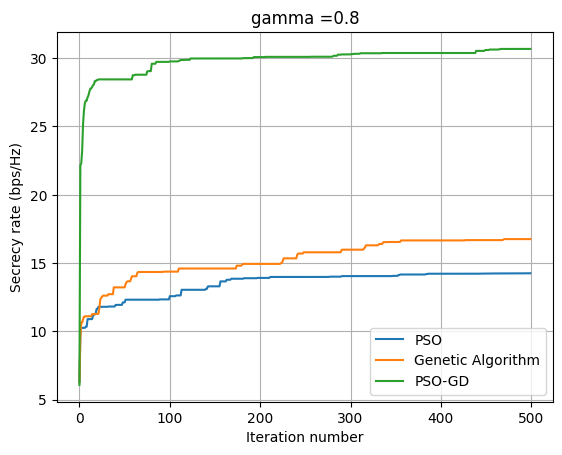

In [ ]:
# iterations = range(0, num_cycles+10, 10)


iterations = range(0, 500)
# Extend the results to the same length
#GD_results_draw = GD_results[:len(iterations)]
PSO_results_draw = PSO_results[:len(iterations)]
GA_results_draw = GA_results[:len(iterations)]
PSO_GD_results_draw = PSO_GD_results[:len(iterations)]
#GA_GD_results_draw = GA_GD_results[:200]


#plt.plot(iterations, GD_results_draw, label='Gradient Descent')
plt.plot(iterations, PSO_results_draw, label='PSO')
plt.plot(iterations, GA_results_draw, label='Genetic Algorithm')
plt.plot(iterations, PSO_GD_results_draw, label='PSO-GD')
#plt.plot(iterations, GA_GD_results_draw, label='GA-GD')

plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.title('gamma =' + str(gamma))
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Best results of each methods
print("Best Secrecy Rate GD:", max(GD_results))
print("Best Secrecy Rate PSO:", max(PSO_results))
print("Best Secrecy Rate GA:", max(GA_results))
print("Best Secrecy Rate PSO-GD:", max(PSO_GD_results))
#print("Best Secrecy Rate GA-GD:", max(GA_GD_results))

Best Secrecy Rate GD: 20.03449468138728
Best Secrecy Rate PSO: 14.256615027974583
Best Secrecy Rate GA: 16.75757982286868
Best Secrecy Rate PSO-GD: 30.676654340894487


# Save results

In [ ]:
def save_general():
    if os.path.exists('results') == False:
        os.mkdir('results')
    os.chdir('results')

    if os.path.exists('general') == False:
        os.mkdir('general')
    os.chdir('general')

    times = RANDOM_SEED
    if os.path.exists(f'{times}_run') == False:
        os.mkdir(f'{times}_run')
        os.chdir(f'{times}_run')
        np.save('GD_results', GD_results)
        np.save('PSO_results', PSO_results)
        np.save('GA_results', GA_results)
        np.save('PSO_GD_results', PSO_GD_results)
        #np.save('GA_GD_results', GA_GD_results)
        os.chdir('..')
    os.chdir('..')
    os.chdir('..')


def save_fixed_eaves():
    if os.path.exists('results') == False:
        os.mkdir('results')
    os.chdir('results')

    if os.path.exists('fixed_eaves') == False:
        os.mkdir('fixed_eaves')
    os.chdir('fixed_eaves')
    if os.path.exists(f'{number_of_users}users_{number_of_eavesdroppers}eaves') == False:
        os.mkdir(f'{number_of_users}users_{number_of_eavesdroppers}eaves')
    os.chdir(f'{number_of_users}users_{number_of_eavesdroppers}eaves')
    times = RANDOM_SEED
    if os.path.exists(f'{times}_run') == False:
        os.mkdir(f'{times}_run')
        os.chdir(f'{times}_run')
        np.save('GD_results', GD_results)
        np.save('PSO_results', PSO_results)
        np.save('GA_results', GA_results)
        np.save('PSO_GD_results', PSO_GD_results)
        #np.save('GA_GD_results', GA_GD_results)
        os.chdir('..')
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')


def save_fixed_users():
    if os.path.exists('results') == False:
        os.mkdir('results')
    os.chdir('results')

    if os.path.exists('fixed_users') == False:
        os.mkdir('fixed_users')
    os.chdir('fixed_users')
    if os.path.exists(f'{number_of_users}users_{number_of_eavesdroppers}eaves') == False:
        os.mkdir(f'{number_of_users}users_{number_of_eavesdroppers}eaves')
    os.chdir(f'{number_of_users}users_{number_of_eavesdroppers}eaves')
    times = RANDOM_SEED
    if os.path.exists(f'{times}_run') == False:
        os.mkdir(f'{times}_run')
        os.chdir(f'{times}_run')
        np.save('GD_results', GD_results)
        np.save('PSO_results', PSO_results)
        np.save('GA_results', GA_results)
        np.save('PSO_GD_results', PSO_GD_results)
        #np.save('GA_GD_results', GA_GD_results)
        os.chdir('..')
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')


save_fixed_users()

In [ ]:
from sys import platform

if platform == 'win32':
  from win11toast import toast
  
  toast(f'Done run {number_of_users} users {number_of_eavesdroppers} eaves run #{RANDOM_SEED}')

ModuleNotFoundError: No module named 'win11toast'